In [79]:
import pandas as pd
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging

import seaborn as sns

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True



In [32]:
key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)

# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 131, 127, 130, 143, 144, 145, 146, 128]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'tenant type', 'age', 'building type', 'solar panels', 'heat pump', 'electric vehicle', 'electric water heating', 'monthly income']

#print(extracted_df)

# Save extracted columns to a new Excel or CSV file if needed

#extracted_df.to_csv("extracted_columns.csv", index=False)

In [33]:

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

#print(extracted_df)


In [41]:
pattern = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekday_normalized/*CH*.csv"
file_paths = glob.glob(pattern)

print(f"Number of files found: {len(file_paths)}")

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

Number of files found: 1464
Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [69]:
train_data = data_3d

n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,n_init=2, max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

Init 1
3.307 --> 2.368 --> 2.238 --> 2.192 --> 2.178 --> 2.175 --> 2.174 --> 2.173 --> 2.172 --> 2.172 --> 2.171 --> 2.170 --> 2.169 --> 2.168 --> 2.167 --> 2.166 --> 2.165 --> 2.164 --> 2.162 --> 2.160 --> 2.157 --> 2.156 --> 2.155 --> 2.155 --> 2.154 --> 2.154 --> 2.154 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 
Init 2
3.204 --> 2.422 --> 2.348 --> 2.303 --> 2.275 --> 2.253 --> 2.227 --> 2.205 --> 2.190 --> 2.179 --> 2.170 --> 2.165 --> 2.161 --> 2.159 --> 2.158 --> 2.156 --> 2.155 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 2.153 --> 


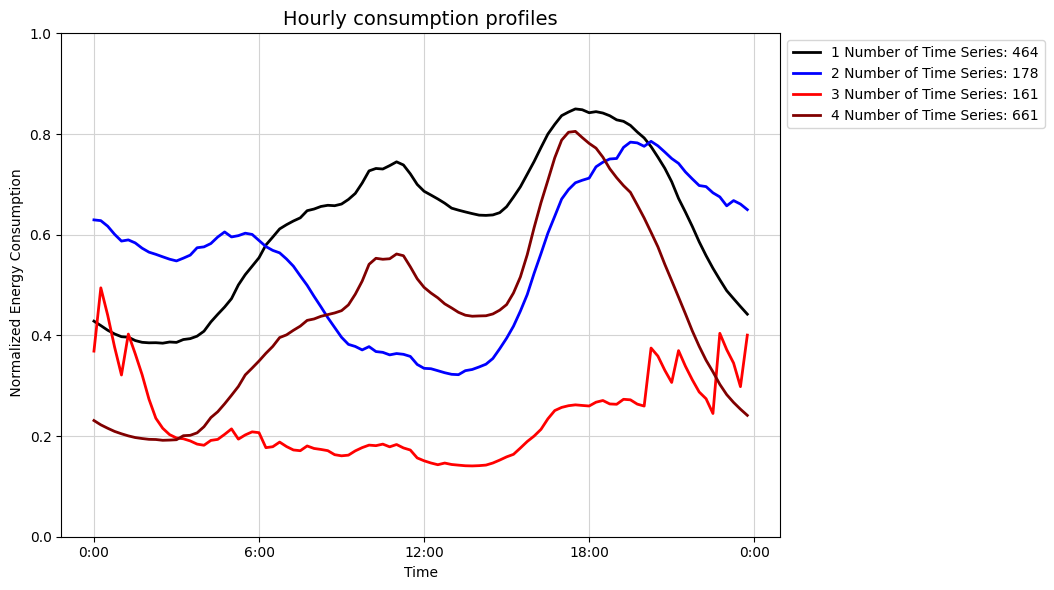

In [75]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title("Hourly consumption profiles", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

plot_clusters_season()

In [70]:
# Convert filename_list items to strings if not already
house_ids = [str(h) for h in filename_list]

# Create Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1  # adjust if needed
})

extracted_pl_df = pl.from_pandas(extracted_df)

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

extracted_pl_df = extracted_pl_df.with_columns(
    pl.col("CH_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

# First join: attach survey columns
joined = result_df.join(
    extracted_pl_df.select([
        "ch_id_clean",
        "tenant type",
        "age",
        "building type",
        "solar panels",
        "heat pump",
        "electric vehicle",
        "electric water heating",
        "monthly income"
    ]),
    on="ch_id_clean",
    how="left"
)

# Second join: attach consumption
joined = joined.join(
    alle_mittelwerte_df.select(["ch_id_clean", "bruttolastgang_kwh_sum"]),
    on="ch_id_clean",
    how="left"
)

# Now select in the desired order
final_df = joined.select([
    "house_id",                # Column 0
    "bruttolastgang_kwh_sum",  # Column 1
    "cluster",                 # Column 2
    "tenant type",
    "age",
    "building type",
    "solar panels",
    "heat pump",
    "electric vehicle",
    "electric water heating",
    "monthly income"
])

#print(final_df.head())

In [71]:
def categorize_consumption(value):
    if value < 5000:
        return "0-5 MWh"
    elif value < 10000:
        return "5-10 MWh"
    elif value < 15000:
        return "10-15 MWh"
    elif value < 20000:
        return "15-20 MWh"
    elif value < 25000:
        return "20-25 MWh"
    else:
        return "25+ MWh"

final_df = final_df.with_columns(
    pl.col("bruttolastgang_kwh_sum")
      .map_elements(categorize_consumption, return_dtype=pl.Utf8)
      .alias("consumption_category")
)

print(final_df.head())

shape: (5, 12)
┌────────────┬────────────┬─────────┬────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ house_id   ┆ bruttolast ┆ cluster ┆ tenant ┆ … ┆ electric   ┆ electric   ┆ monthly   ┆ consumpti │
│ ---        ┆ gang_kwh_s ┆ ---     ┆ type   ┆   ┆ vehicle    ┆ water      ┆ income    ┆ on_catego │
│ str        ┆ um         ┆ i64     ┆ ---    ┆   ┆ ---        ┆ heating    ┆ ---       ┆ ry        │
│            ┆ ---        ┆         ┆ str    ┆   ┆ str        ┆ ---        ┆ str       ┆ ---       │
│            ┆ f64        ┆         ┆        ┆   ┆            ┆ str        ┆           ┆ str       │
╞════════════╪════════════╪═════════╪════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 4790.208   ┆ 4       ┆ null   ┆ … ┆ yes        ┆ no         ┆ null      ┆ 0-5 MWh   │
│ 3450000000 ┆            ┆         ┆        ┆   ┆            ┆            ┆           ┆           │
│ 0000000040 ┆            ┆         ┆        ┆   ┆            ┆            ┆

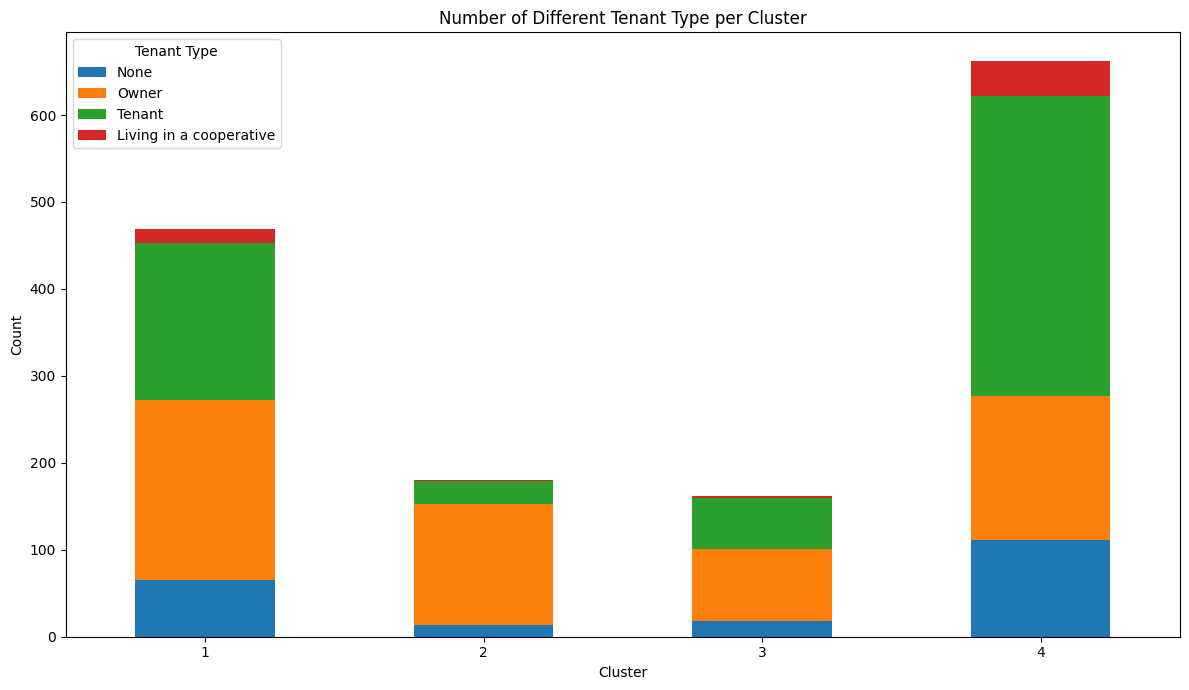

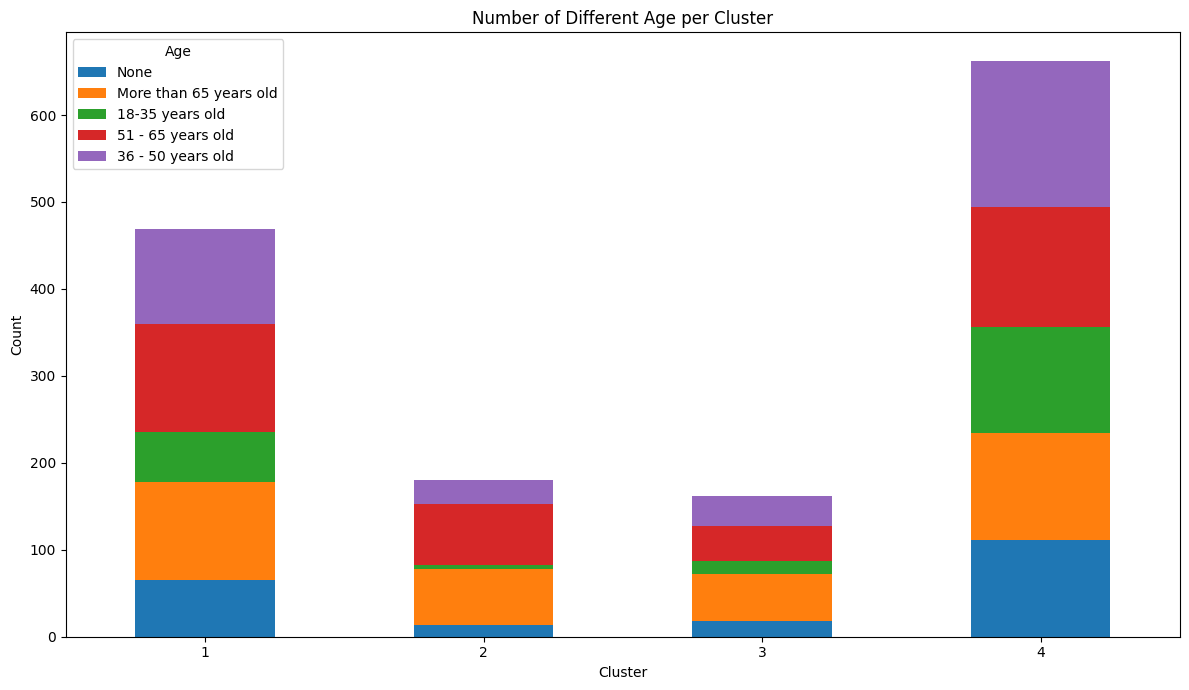

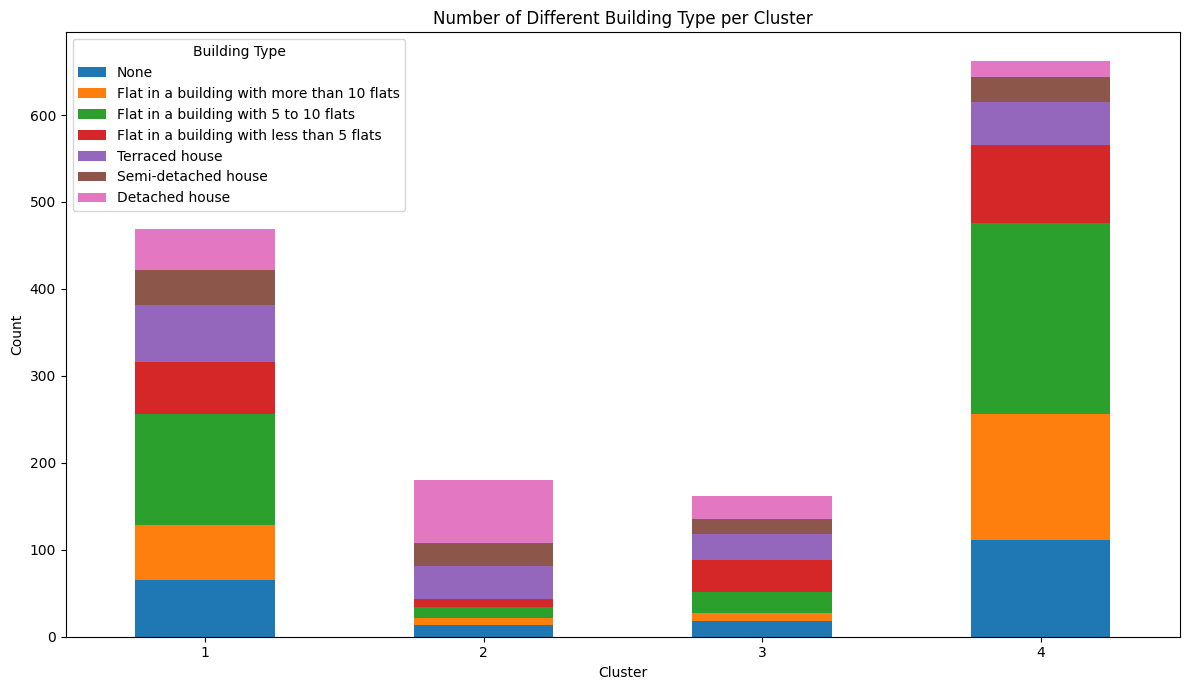

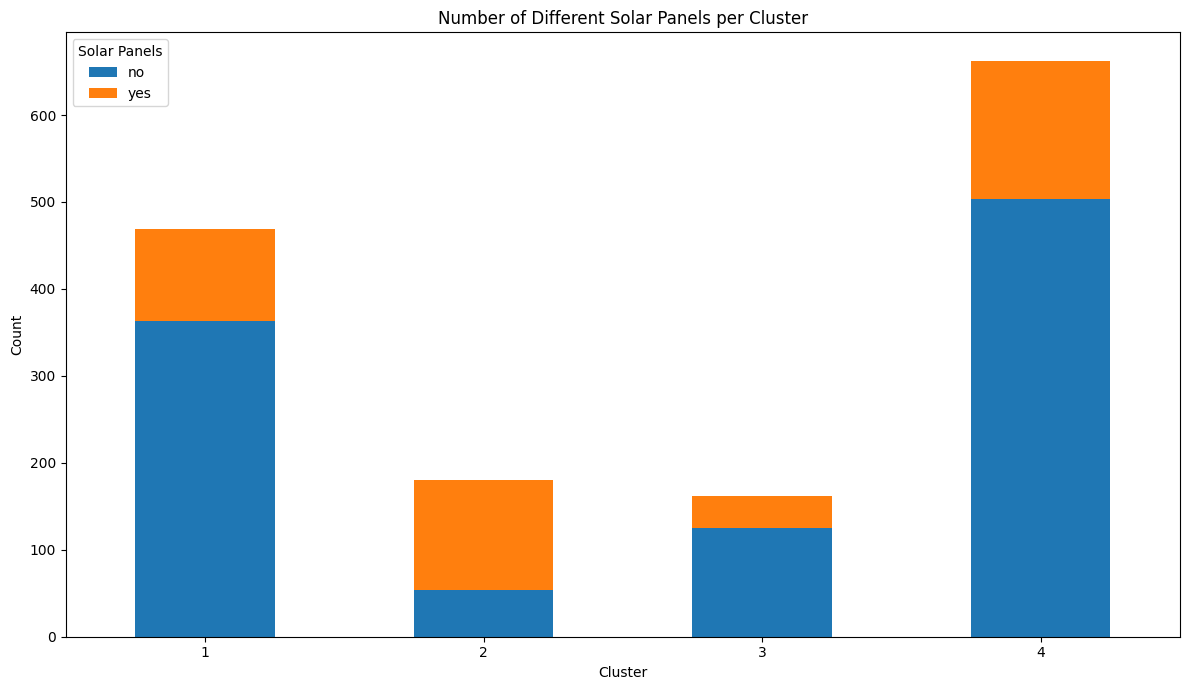

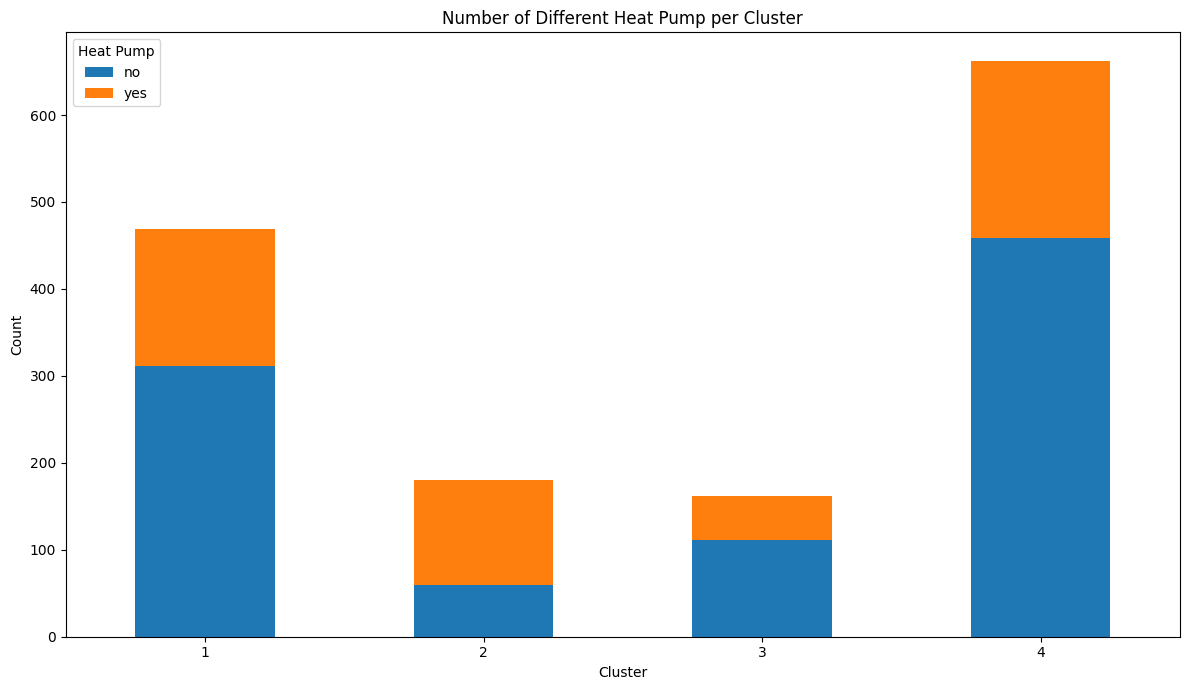

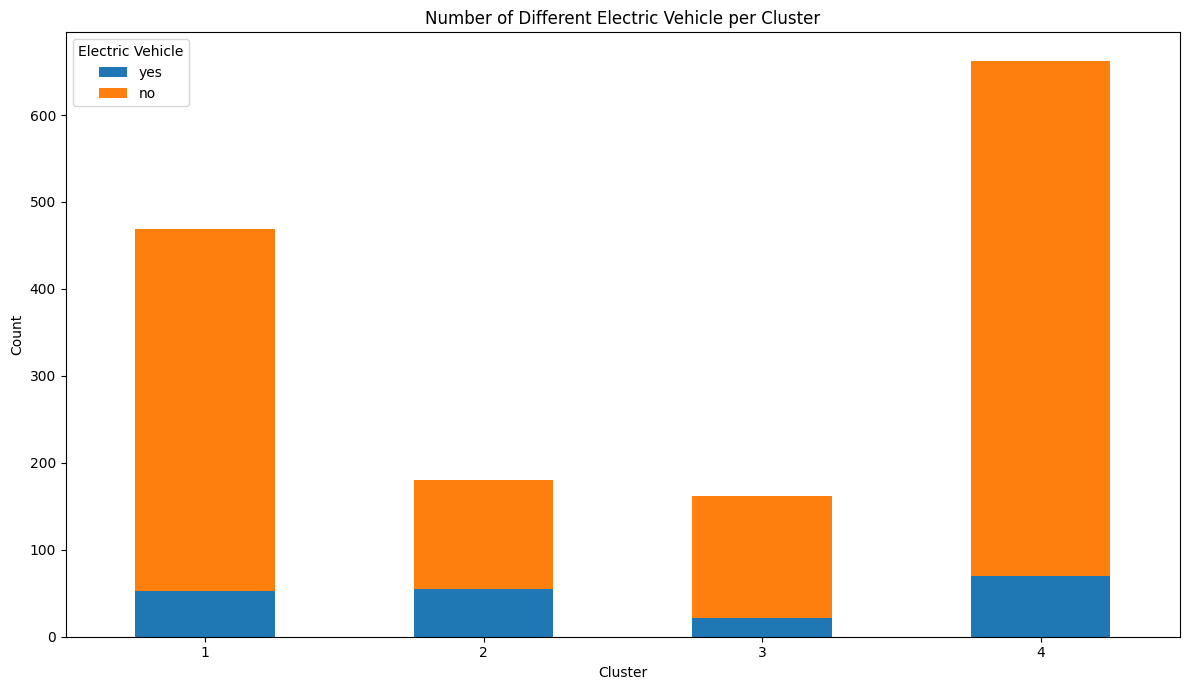

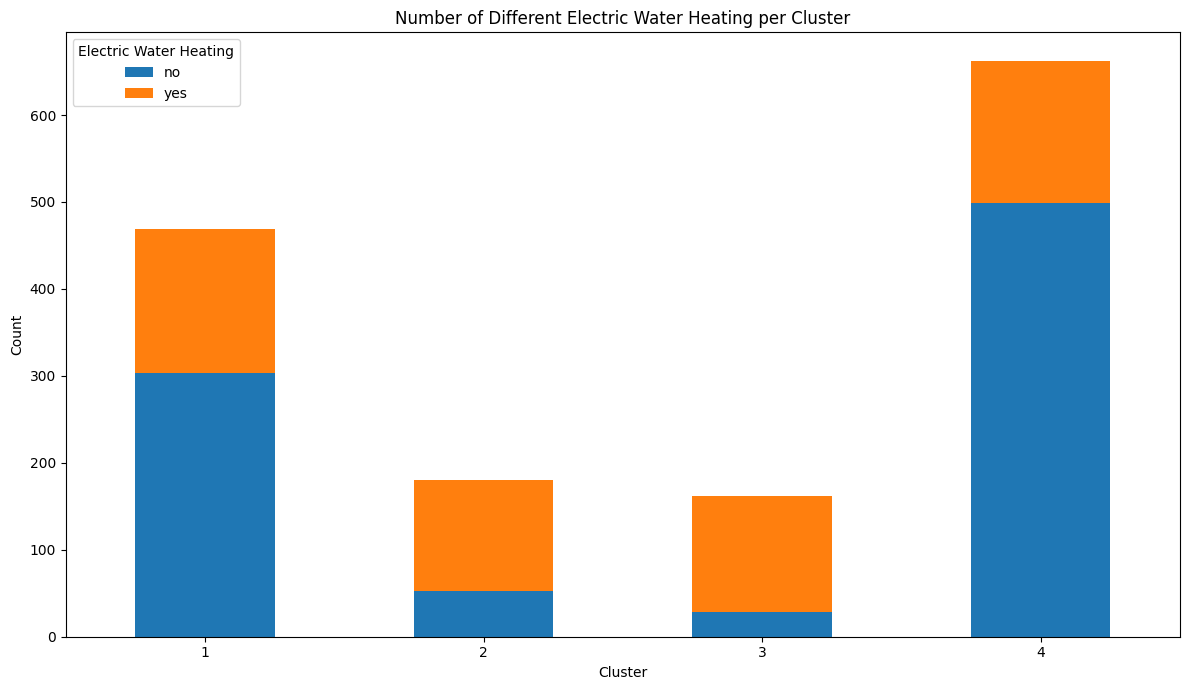

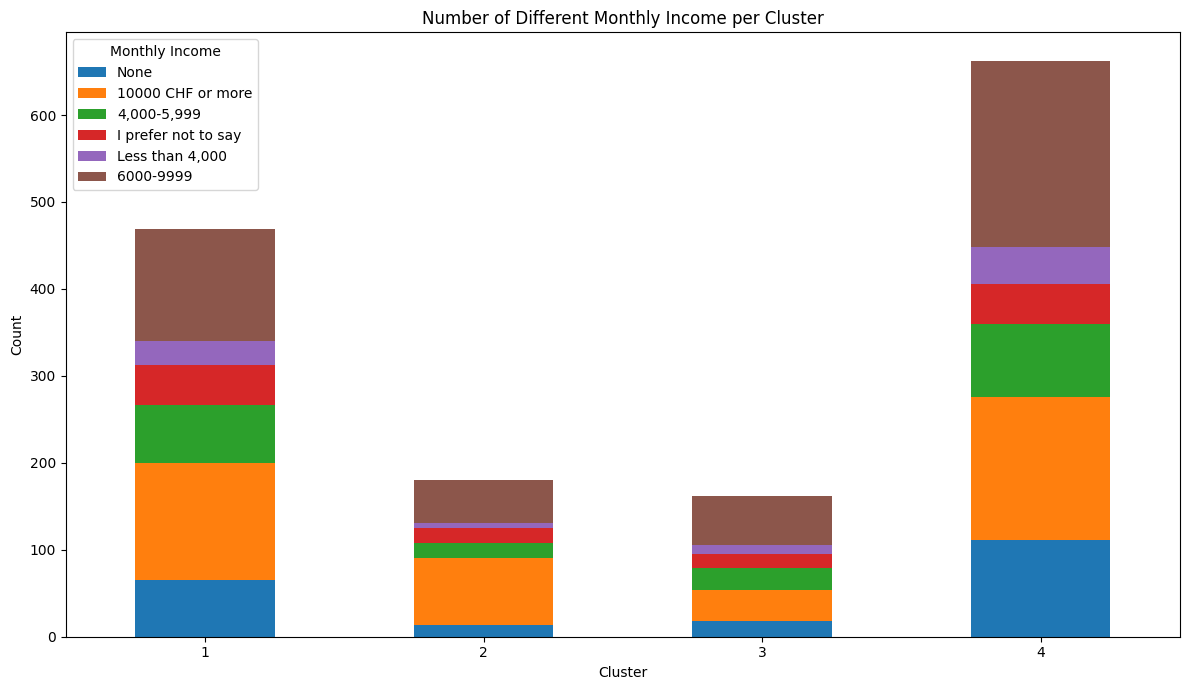

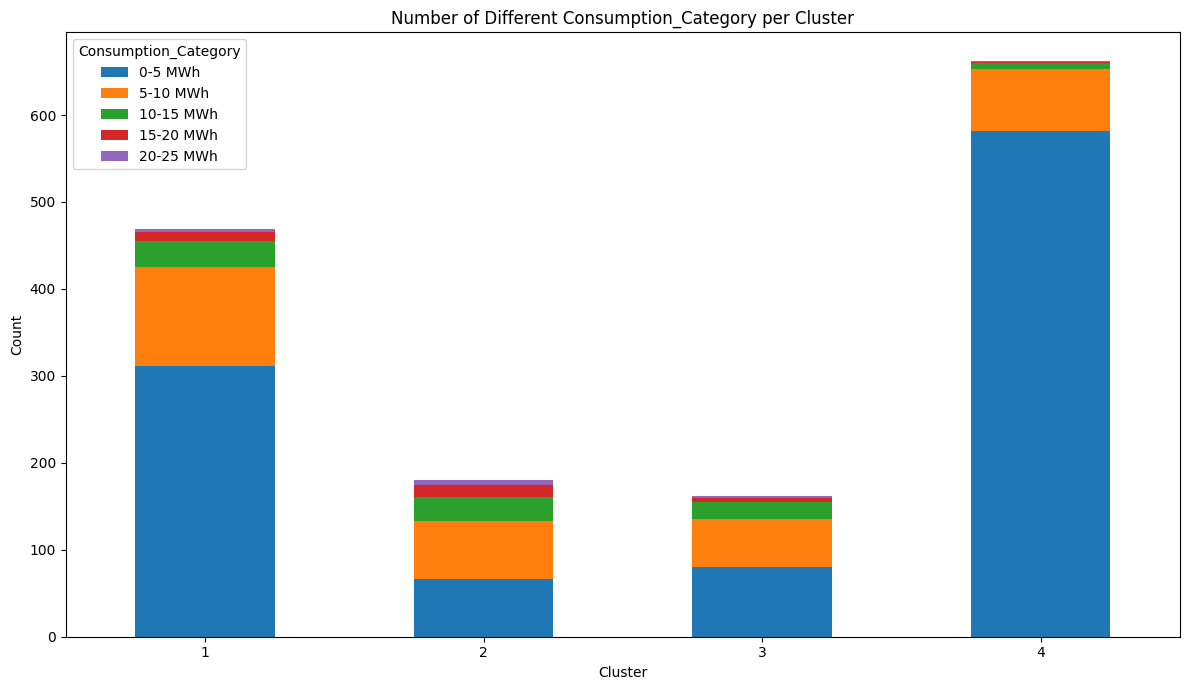

In [72]:
final_df_absolut = final_df.to_pandas()

clusters = sorted(final_df_absolut['cluster'].unique())

# Start from the second column, exclude 'cluster' explicitly
cols = final_df_absolut.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

for col in category_columns:
    final_df_absolut[col] = final_df_absolut[col].astype(str)
    categories = final_df_absolut[col].unique()
    counts = {cat: [] for cat in categories}

    for cl in clusters:
        cluster_subset = final_df_absolut[final_df_absolut['cluster'] == cl]
        for cat in categories:
            count_cat = sum(cluster_subset[col] == cat)
            counts[cat].append(count_cat)

    count_df = pd.DataFrame(counts, index=clusters)

    ax = count_df.plot(kind='bar', stacked=True, figsize=(12, 7))
    ax.set_title(f"Number of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=col.title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



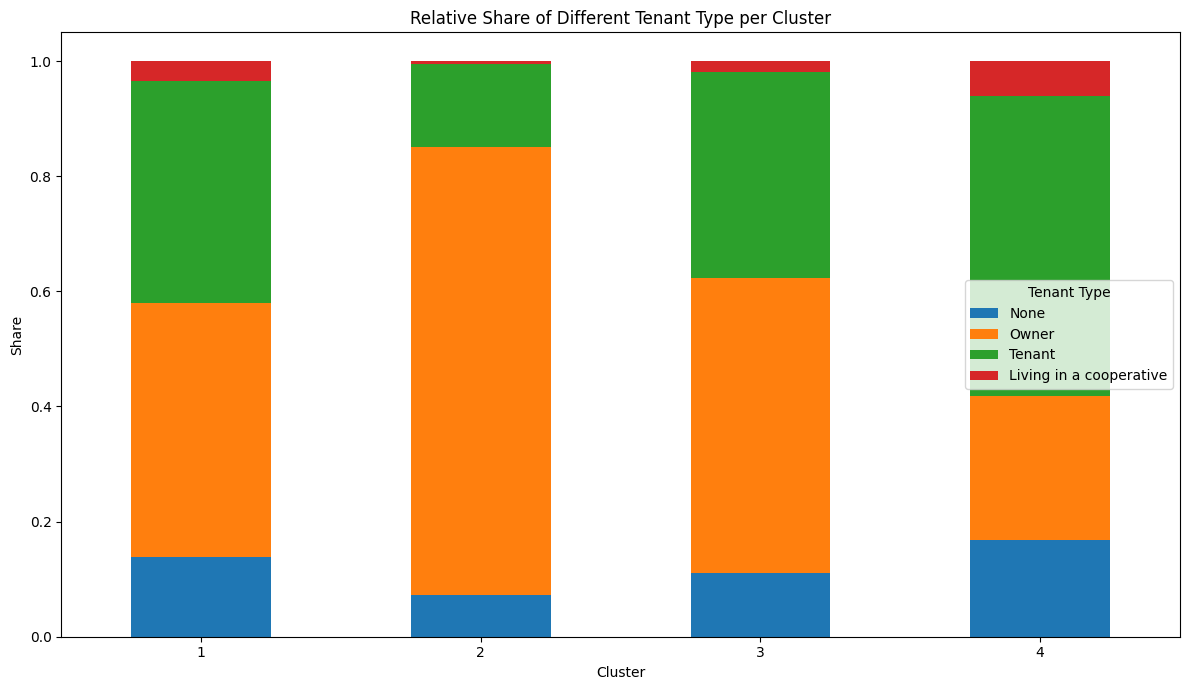

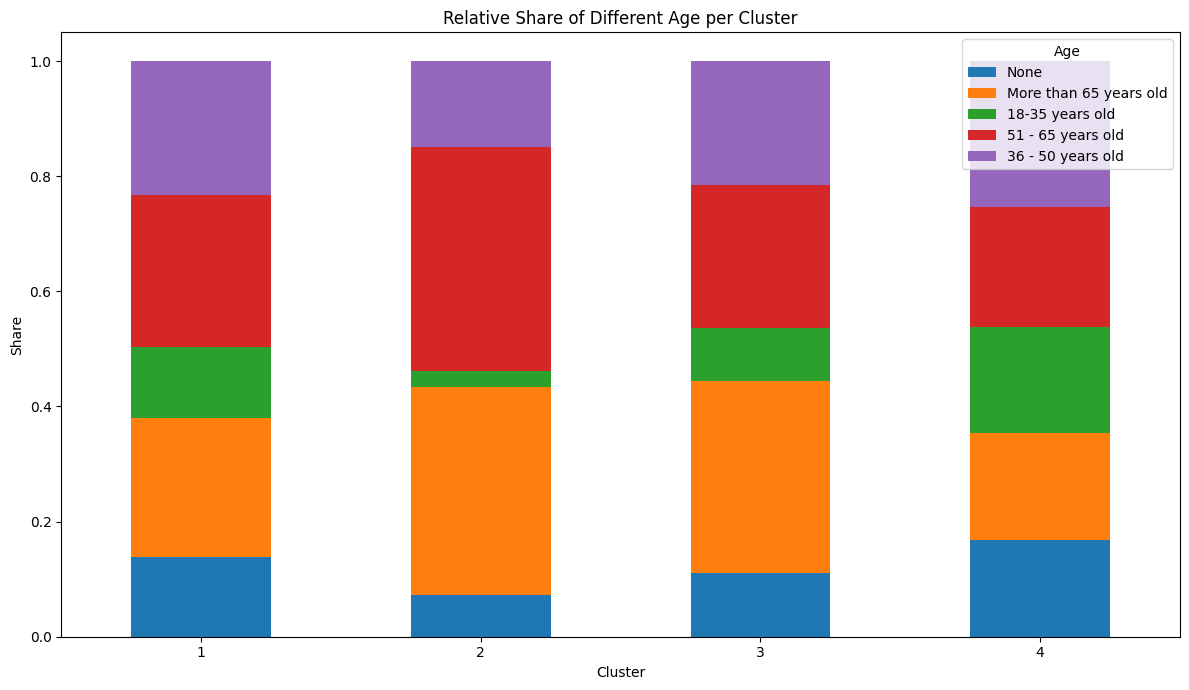

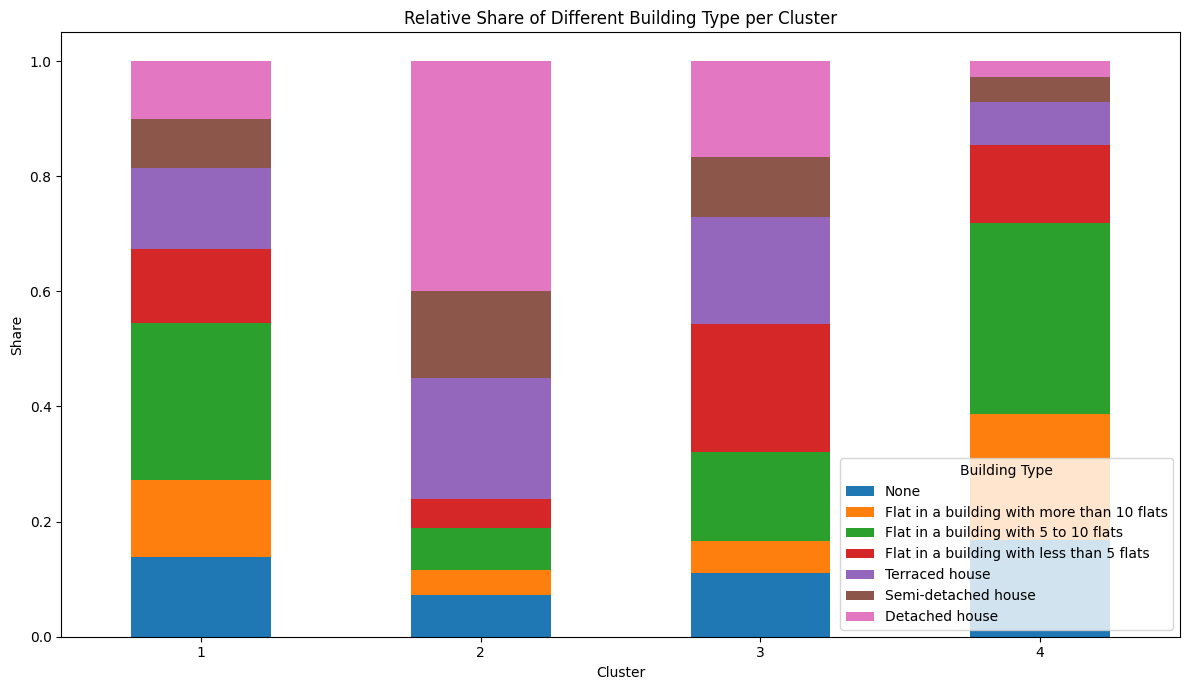

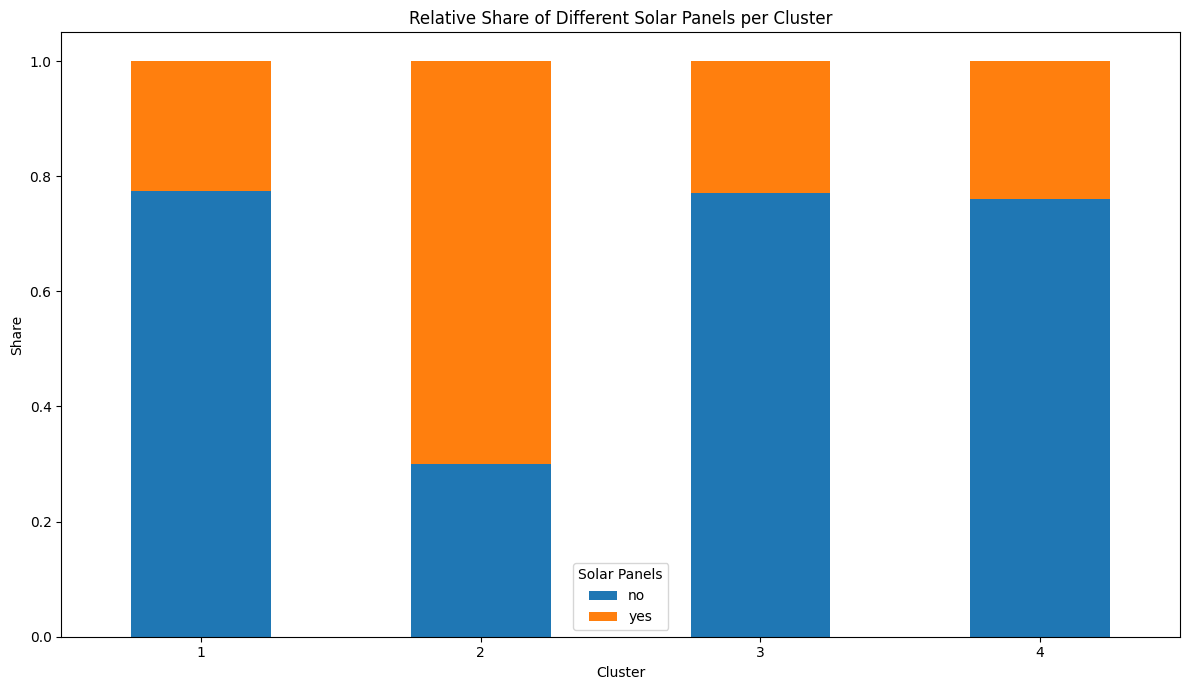

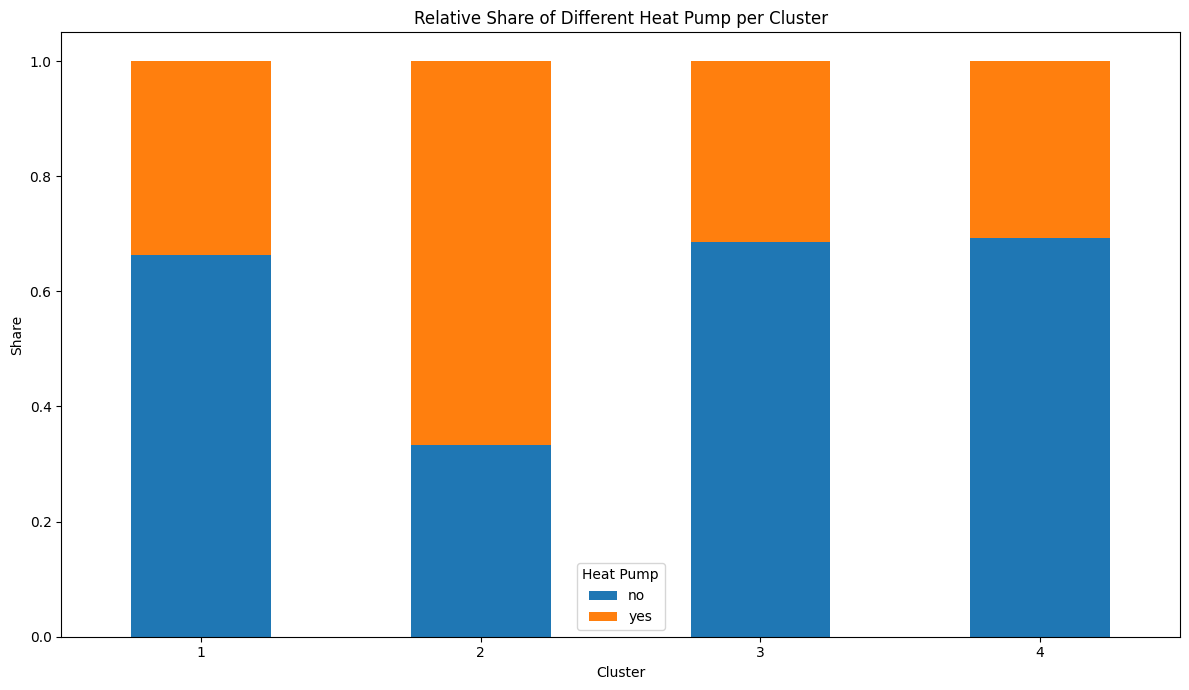

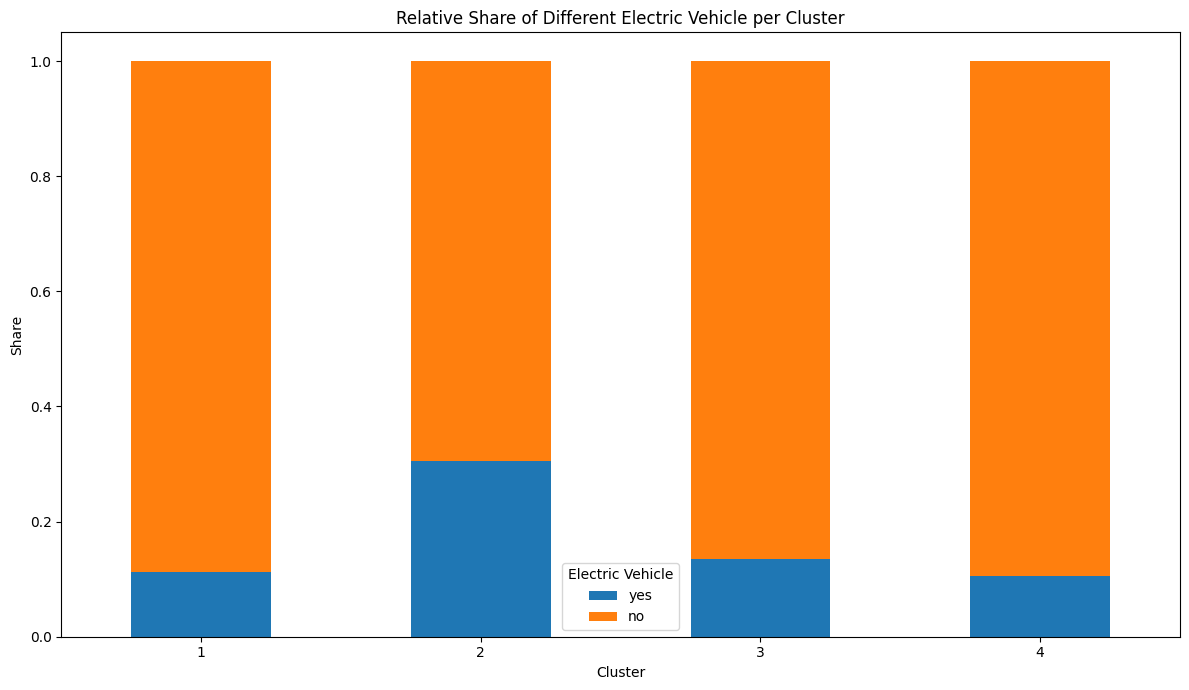

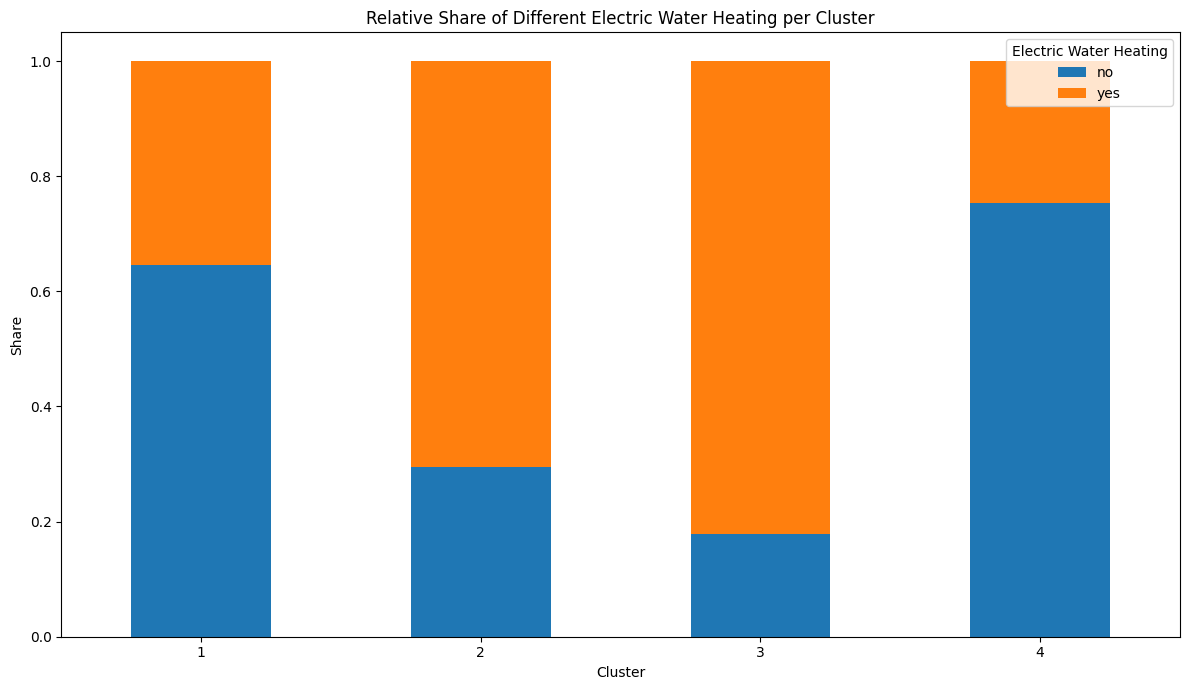

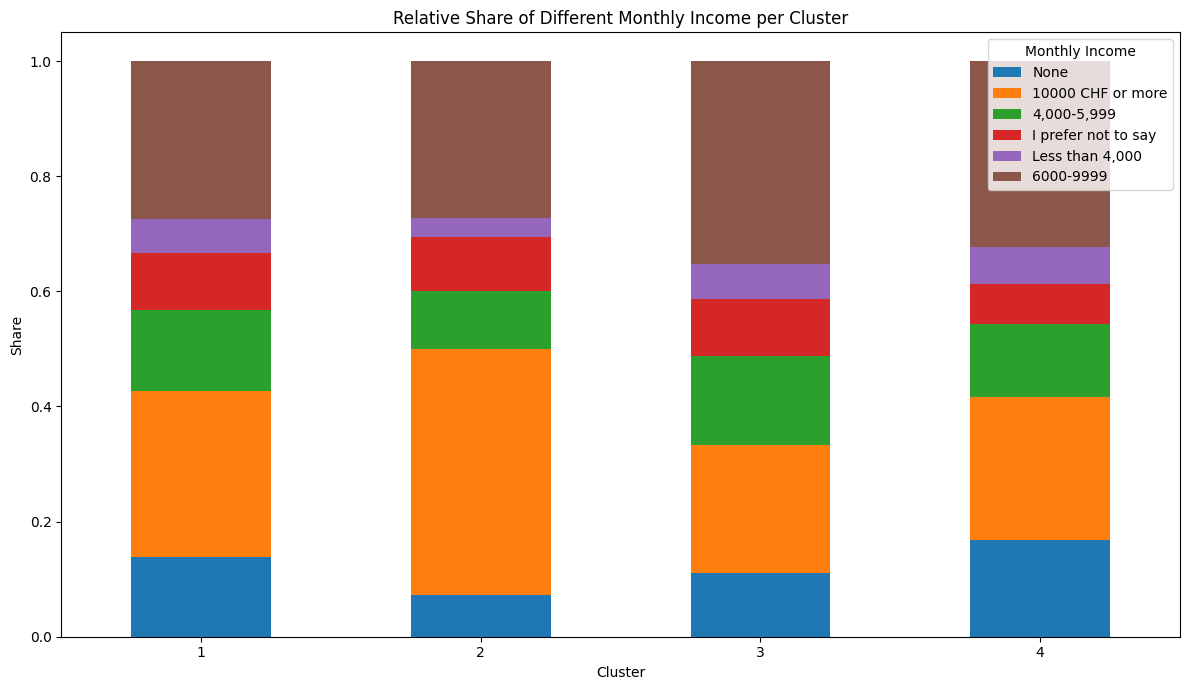

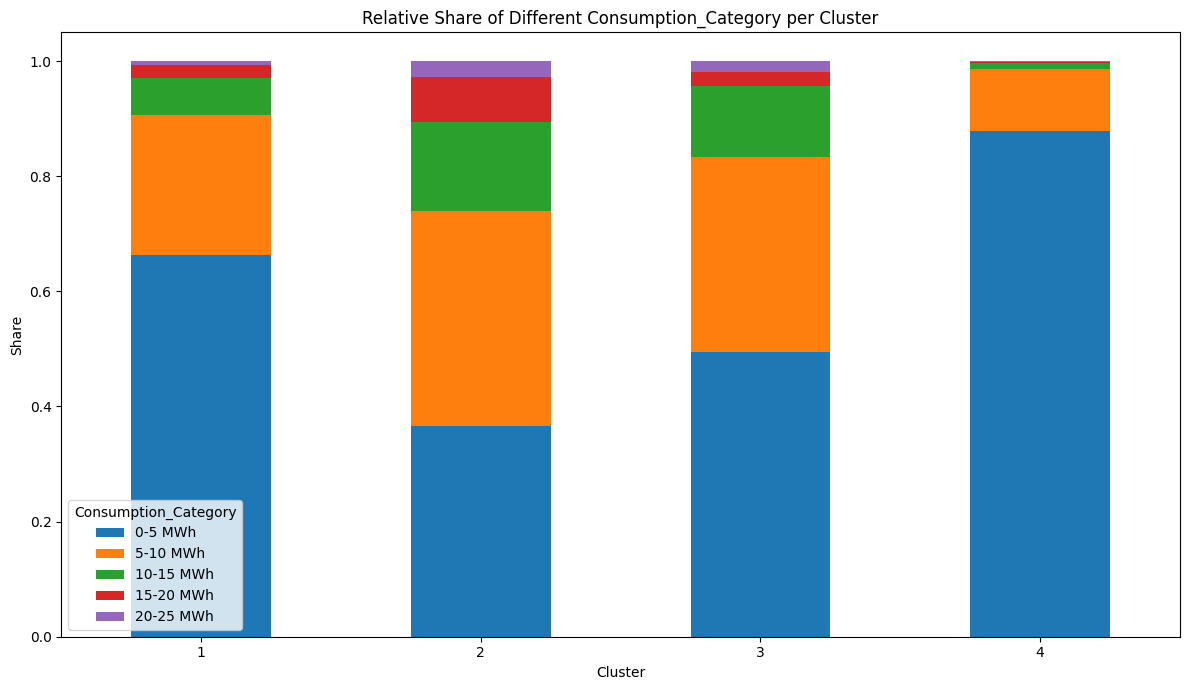

In [73]:
final_df_relative = final_df.to_pandas()

clusters = sorted(final_df_relative['cluster'].unique())

# Start from the second column, exclude 'cluster' explicitly
cols = final_df_relative.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

for col in category_columns:
    final_df_relative[col] = final_df_relative[col].astype(str)
    categories = final_df_relative[col].unique()
    counts = {cat: [] for cat in categories}

    for cl in clusters:
        cluster_subset = final_df_relative[final_df_relative['cluster'] == cl]
        total_in_cluster = len(cluster_subset)
        for cat in categories:
            count_cat = sum(cluster_subset[col] == cat)
            # Compute proportion instead of raw count
            prop_cat = count_cat / total_in_cluster if total_in_cluster > 0 else 0
            counts[cat].append(prop_cat)

    prop_df = pd.DataFrame(counts, index=clusters)
    
    ax = prop_df.plot(kind='bar', stacked=True, figsize=(12, 7))
    ax.set_title(f"Relative Share of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Share")
    ax.legend(title=col.title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

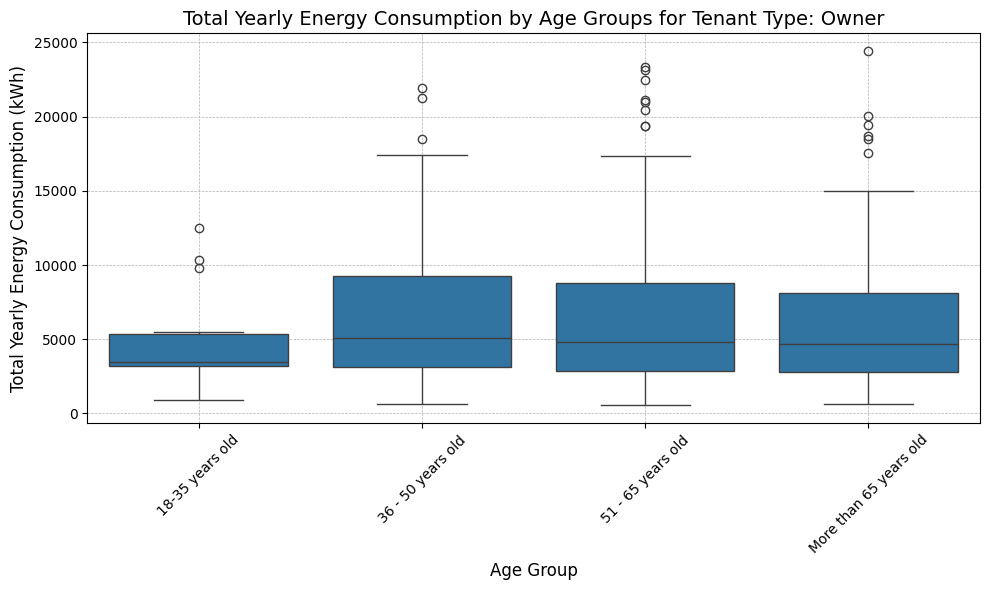

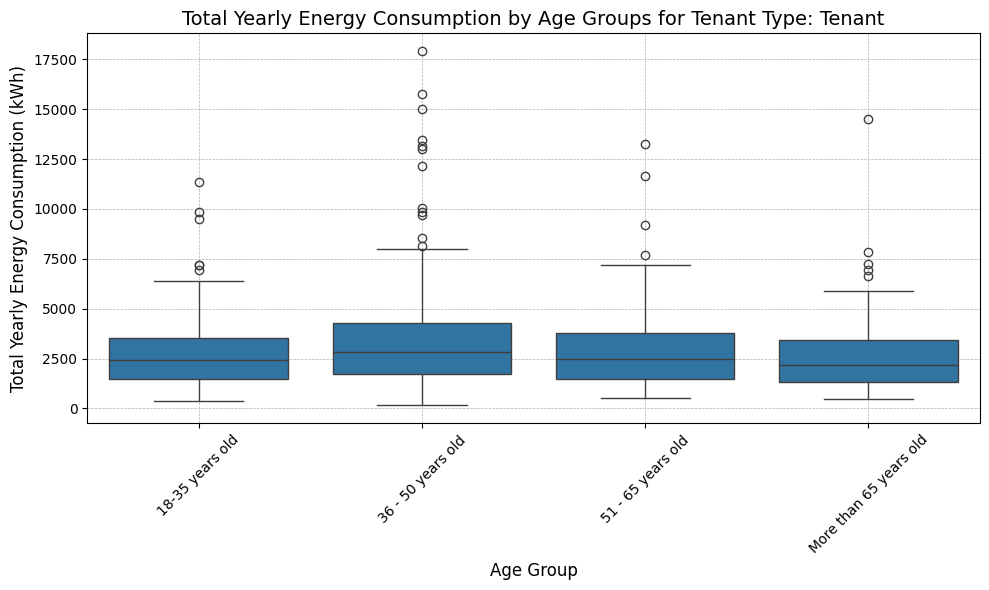

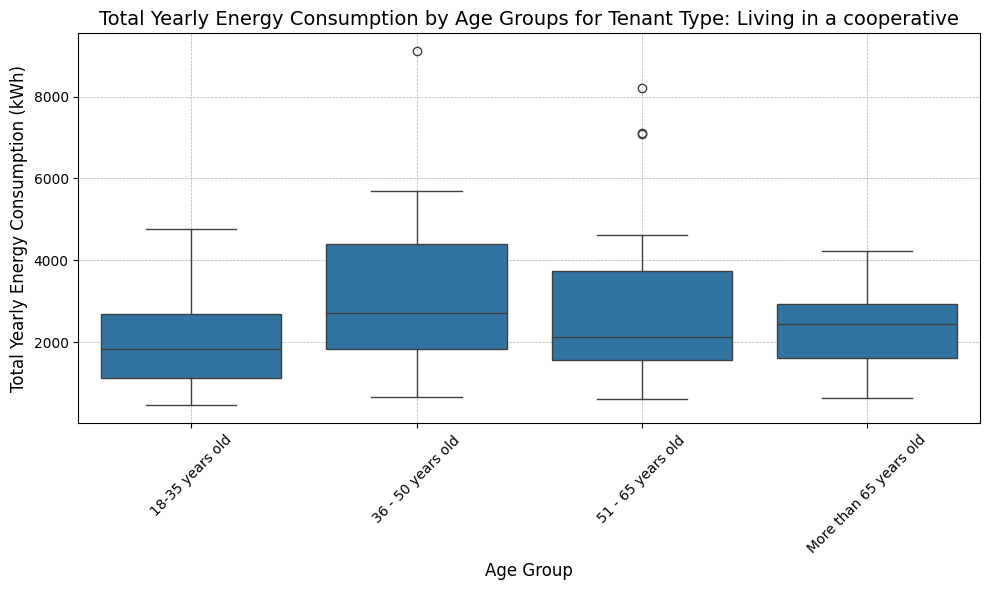

In [81]:
# Assuming final_df_absolut contains the relevant columns: 'tenant type', 'age', 'bruttolastgang_kwh_sum'

tenant_type_order = [
    'Owner',
    'Tenant',
    'Living in a cooperative'
]

age_order = [
    '18-35 years old',
    '36 - 50 years old',
    '51 - 65 years old',
    'More than 65 years old'
]

for tenant_type in tenant_type_order:
    plot_df = final_df_absolut[
        (final_df_absolut['tenant type'] == tenant_type) &
        (final_df_absolut['age'].isin(age_order))
    ]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=plot_df, x='age', y='bruttolastgang_kwh_sum', order=age_order)
    
    plt.title(f'Total Yearly Energy Consumption by Age Groups for Tenant Type: {tenant_type}', fontsize=14)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Total Yearly Energy Consumption (kWh)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

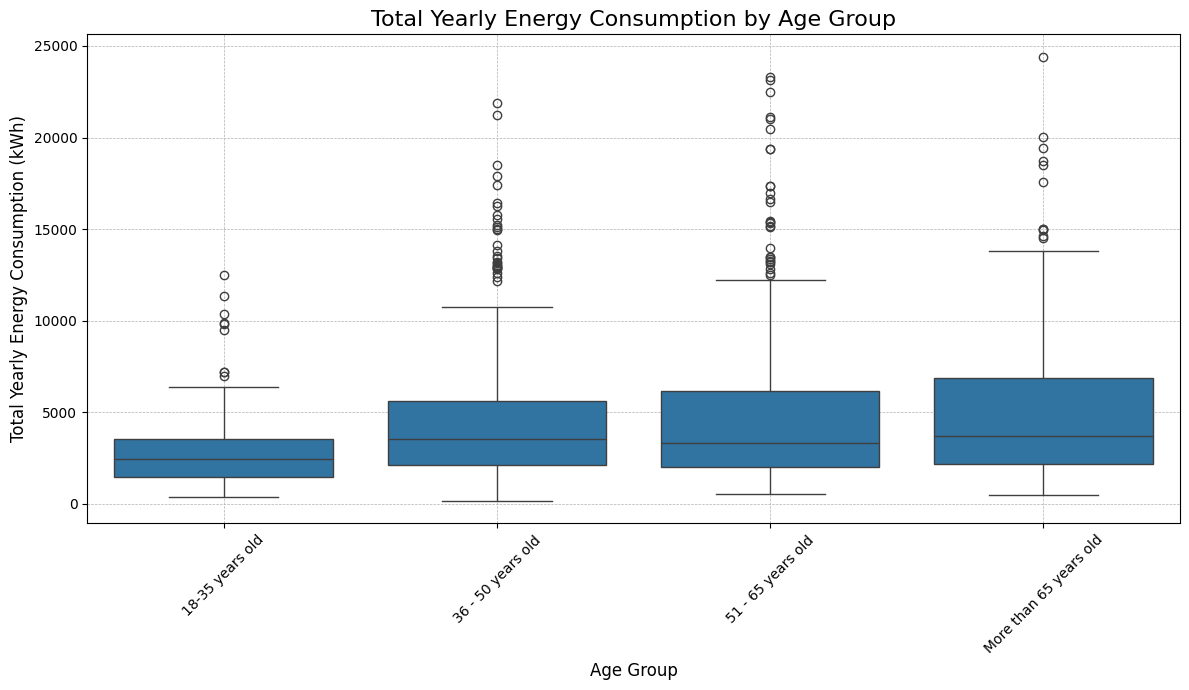

In [80]:


# Define the desired order for the age categories
age_order = [
    '18-35 years old',
    '36 - 50 years old',
    '51 - 65 years old',
    'More than 65 years old'
]

# Filter out rows where age is 'None' or other non-standard entries
plot_df = final_df_absolut[final_df_absolut['age'].isin(age_order)]

# Create the plot
plt.figure(figsize=(12, 7))
sns.boxplot(data=plot_df, x='age', y='bruttolastgang_kwh_sum', order=age_order)

# Set plot titles and labels
plt.title('Total Yearly Energy Consumption by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Total Yearly Energy Consumption (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()